In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
import datetime


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Edge Final Project/Yahoo Dataset/yahoo_raw_data/df_adj_close.csv', index_col=0)

data = data.iloc[2:]
data.index = pd.to_datetime(data.index).date
data.index = pd.to_datetime(data.index)
data = data.astype(float)
data.loc[data.index < pd.to_datetime('2011-01-01'), 'PNL'] = data.loc[data.index < pd.to_datetime('2011-01-01'), 'PNL'].apply(lambda x: x / 100)


data = data['2017':'2022']

In [4]:
cluster = pd.read_csv('/content/drive/MyDrive/Edge Final Project/Clustering results/stock_5_cluster_df.csv')

In [5]:
data = data[list(cluster['Ticker'])]
data = data.dropna(axis=1)
data

,3IN,FOUR,ABDN,ALW,ATT,ASHM,DGN,AGR,AGT,BGFD,...,VSVS,VCT,VOF,JDW,SMWH,WG,WKP,WWH,ZIG,ASL
2017-01-03,193.466919,1506.214478,236.336594,633.503723,83.025002,178.105286,303.100891,38.422039,128.612762,576.178711,...,292.347565,1498.385254,272.698456,840.359009,1349.641479,654.553162,571.695435,211.866669,326.510529,1097.930786
2017-01-04,193.052505,1558.152954,236.024658,638.468445,83.150002,185.775803,305.973267,38.899757,129.112045,581.675720,...,293.078003,1508.462280,272.199463,836.061646,1346.138062,653.811462,580.628235,214.265167,333.471741,1093.974487
2017-01-05,193.778107,1511.240845,226.603668,641.447449,83.000000,189.517502,306.972443,38.592655,128.812454,580.676208,...,292.931915,1513.888550,271.949951,846.088684,1386.425781,657.519958,588.444458,216.663651,342.090271,1096.942139
2017-01-06,193.674942,1528.833008,227.102783,644.426208,83.500000,186.648849,308.346130,38.899757,129.012161,583.424683,...,293.516357,1504.586670,272.448975,850.385925,1387.301758,659.745117,594.027405,218.762329,340.432831,1097.930786
2017-01-09,193.466919,1548.100342,224.919144,652.866333,84.199997,178.042953,313.216766,38.695023,130.210464,594.668396,...,292.201416,1506.136963,272.947937,850.863403,1397.811401,663.453735,577.650635,223.359421,348.719879,1094.963379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,317.167389,4023.311523,155.835922,930.475708,206.500000,194.741806,419.917267,46.838127,186.535660,753.782104,...,355.944672,1454.924927,442.753387,422.292847,1443.464600,135.399994,392.774750,324.449280,370.457520,1287.995850
2022-12-23,319.128265,4143.548828,156.296875,931.469849,206.500000,192.732422,421.916870,47.409866,187.335403,755.781494,...,360.975677,1485.389526,442.753387,427.207794,1424.668457,135.000000,393.316193,325.949036,372.238556,1301.866577
2022-12-28,323.049957,3967.817871,157.176819,932.463928,205.500000,195.746490,421.916870,47.365883,187.335403,761.779785,...,364.209900,1480.773804,448.750061,428.977173,1437.681274,134.699997,400.897339,322.949463,371.793304,1299.885132
2022-12-29,325.991211,3977.066895,158.936737,942.404907,212.500000,200.602478,425.916077,48.069557,188.335037,760.780090,...,363.131866,1476.157959,448.250336,434.088745,1426.596191,138.750000,402.882874,325.449127,372.683868,1311.774292


In [6]:

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset.to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)


def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

def calculate_mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
    - y_true: Array of actual values.
    - y_pred: Array of predicted values.

    Returns:
    - mape: Mean Absolute Percentage Error.
    """
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    return mape


In [7]:
train_start_date = "2017-01-01"
train_end_date = "2021-12-31"
test_start_date = "2022-01-01"
test_end_date = "2022-12-30"

## By INDIVIDUAL Stock

In [ ]:
rmse = []
ticker_ls = list(data.columns)
for i in range(140,len(ticker_ls)):
  ticker = ticker_ls[i]
  df = data[ticker]
  ### CREATE WINDOW ###
  windowed_df = df_to_windowed_df(df,
                                '2017-01-06',
                                '2022-12-30',
                                n=3)

  dates, X, y = windowed_df_to_date_X_y(windowed_df)
  dates = pd.to_datetime(dates)

  ### TRAIN VAL TEST SPLIT ###
  train_mask = (dates >= train_start_date) & (dates <= train_end_date)
  test_mask = (dates >= test_start_date) & (dates <= test_end_date)
  dates_train_full, X_train_full, y_train_full = dates[train_mask], X[train_mask], y[train_mask]

  split_index = int(len(dates_train_full) * 0.9)

  dates_train, X_train, y_train = (
      dates_train_full[:split_index],
      X_train_full[:split_index],
      y_train_full[:split_index],
  )
  dates_val, X_val, y_val = (
      dates_train_full[split_index:],
      X_train_full[split_index:],
      y_train_full[split_index:],
  )

  dates_test, X_test, y_test = dates[test_mask], X[test_mask], y[test_mask]

  ### MODEL TRAINING ###

  # model = Sequential([layers.Input((3, 1)),
  #                   layers.LSTM(64),
  #                   layers.Dense(32, activation='relu'),
  #                   layers.Dense(32, activation='relu'),
  #                   layers.Dense(1)])
  model = Sequential([
    layers.Input((3, 1)),
    layers.LSTM(256, return_sequences=True),
    layers.LSTM(128),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
  model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])
  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

  ### PREDICTIONS ###
  # train_predictions = model.predict(X_train).flatten()
  # val_predictions = model.predict(X_val).flatten()
  test_predictions = model.predict(X_test).flatten()
  test_mse = mean_squared_error(y_test, test_predictions)
  test_rmse = np.sqrt(test_mse)
  print(f"{ticker}",f"Testing RMSE: {test_rmse}")
  test_mape = calculate_mape(y_test, test_predictions)
  print(f"Testing MAPE: {test_mape:.2f}%")
  rmse.append({'stock': ticker, 'rmse': test_rmse, 'mape': test_mape})


rmse_df = pd.DataFrame(rmse)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 150323.0938 - mean_absolute_error: 385.3552 - val_loss: 233496.4844 - val_mean_absolute_error: 483.0599
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 123585.2344 - mean_absolute_error: 348.8199 - val_loss: 167678.5781 - val_mean_absolute_error: 409.3031
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 69920.3750 - mean_absolute_error: 258.8099 - val_loss: 69234.8906 - val_mean_absolute_error: 262.8409
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13745.2402 - mean_absolute_error: 104.1384 - val_loss: 16775.5898 - val_mean_absolute_error: 128.9420
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1785.9292 - mean_absolute_error: 35.6221 - val_loss: 13598.5059 - val_mean_absolute_error: 115.9696
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2001.1603 - mean_absolute_error: 38.3857 - val_loss: 14792.2188 - val_mean_absolute_error: 121.0069
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
SRP Testing RMSE: 8.374285697937012
Testing MAPE: 3.55%
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 47255.3281 - mean_absolute_error: 210.8584 - val_loss: 17723.8027 - val_mean_absolute_error: 133.0368
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34185.0391 - mean_absolute_error: 177.0462 - val_loss: 4677.5435 - val_mean_absolute_error: 68.2095
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12311.0078 - mean_absolute_error: 98.2319 - val_loss: 1182.9830 - val_mean_absolute_error: 34.0290
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2882.2263 - mean_absolute_error: 46.7771 - val_loss: 3466.3230 - val_mean_absolute_error: 58.6627
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2707.7683 - mean_absolute_error: 44.6873 - val_loss: 3030.2380 - val_mean_absolute_error: 54.8199
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2658.6580 - mean_absolute_error: 44.0185 - val_loss: 4

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
SHC Testing RMSE: 2.7711079120635986
Testing MAPE: 1.67%
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2725.0356 - mean_absolute_error: 50.0359 - val_loss: 6695.0059 - val_mean_absolute_error: 81.4915
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 438.9226 - mean_absolute_error: 16.5698 - val_loss: 2978.7529 - val_mean_absolute_error: 54.0808
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 191.2026 - mean_absolute_error: 11.6767 - val_loss: 3275.4534 - val_mean_absolute_error: 56.7577
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 184.5824 - mean_absolute_error: 11.4195 - val_loss: 3282.3091 - val_mean_absolute_error: 56.8181
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 184.5014 - mean_absolute_error: 11.4842 - val_loss: 3474.9993 - val_mean_absolute_error: 58.4892
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 189.5696 - mean_absolute_error: 11.3153 - val_loss: 3236.5596 - 

KeyboardInterrupt: 

In [ ]:
rmse_df = pd.DataFrame(rmse)
rmse_df.to_csv('rmse_df.csv')
rmse_df.to_csv('/content/drive/MyDrive/Edge Final Project/rmse_df.csv')


In [ ]:
rmse_df

,stock,rmse,mape
0,PAY,13.518757,2.262351
1,PNN,17.555544,1.589320
2,PNL,9.878707,1.753645
3,PTEC,17.535572,2.023015
4,PCT,5.412064,1.927539
5,PPH,36.134617,2.225473
6,PFD,5.062794,3.556972
7,PHP,1.750645,1.207456
8,PZC,2.951108,1.280500
9,QQ,7.708693,1.780044


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


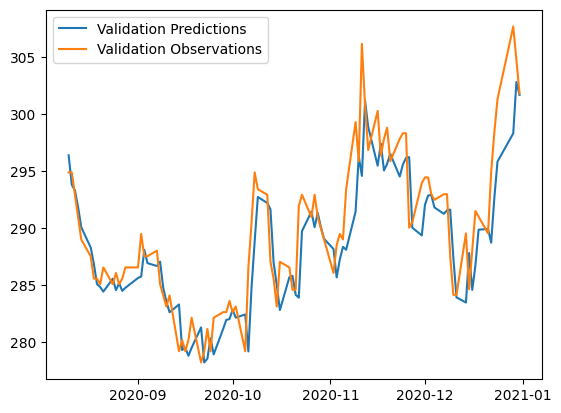

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


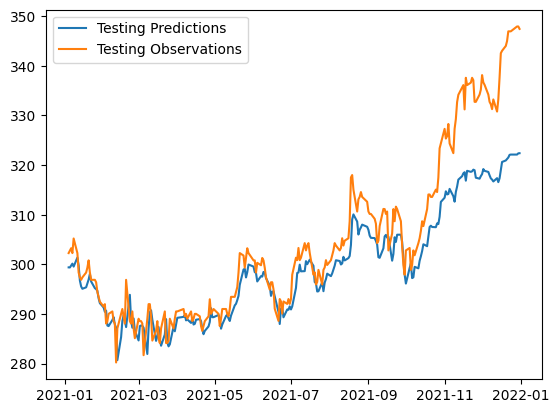

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
from sklearn.metrics import mean_squared_error

test_mse = mean_squared_error(y_test, test_predictions)

# Print the MSE
print(f"Testing Mean Squared Error: {test_mse}")


Testing Mean Squared Error: 70.36192321777344


## Cluster of training data

In [8]:
data

,3IN,FOUR,ABDN,ALW,ATT,ASHM,DGN,AGR,AGT,BGFD,...,VSVS,VCT,VOF,JDW,SMWH,WG,WKP,WWH,ZIG,ASL
2017-01-03,193.466919,1506.214478,236.336594,633.503723,83.025002,178.105286,303.100891,38.422039,128.612762,576.178711,...,292.347565,1498.385254,272.698456,840.359009,1349.641479,654.553162,571.695435,211.866669,326.510529,1097.930786
2017-01-04,193.052505,1558.152954,236.024658,638.468445,83.150002,185.775803,305.973267,38.899757,129.112045,581.675720,...,293.078003,1508.462280,272.199463,836.061646,1346.138062,653.811462,580.628235,214.265167,333.471741,1093.974487
2017-01-05,193.778107,1511.240845,226.603668,641.447449,83.000000,189.517502,306.972443,38.592655,128.812454,580.676208,...,292.931915,1513.888550,271.949951,846.088684,1386.425781,657.519958,588.444458,216.663651,342.090271,1096.942139
2017-01-06,193.674942,1528.833008,227.102783,644.426208,83.500000,186.648849,308.346130,38.899757,129.012161,583.424683,...,293.516357,1504.586670,272.448975,850.385925,1387.301758,659.745117,594.027405,218.762329,340.432831,1097.930786
2017-01-09,193.466919,1548.100342,224.919144,652.866333,84.199997,178.042953,313.216766,38.695023,130.210464,594.668396,...,292.201416,1506.136963,272.947937,850.863403,1397.811401,663.453735,577.650635,223.359421,348.719879,1094.963379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,317.167389,4023.311523,155.835922,930.475708,206.500000,194.741806,419.917267,46.838127,186.535660,753.782104,...,355.944672,1454.924927,442.753387,422.292847,1443.464600,135.399994,392.774750,324.449280,370.457520,1287.995850
2022-12-23,319.128265,4143.548828,156.296875,931.469849,206.500000,192.732422,421.916870,47.409866,187.335403,755.781494,...,360.975677,1485.389526,442.753387,427.207794,1424.668457,135.000000,393.316193,325.949036,372.238556,1301.866577
2022-12-28,323.049957,3967.817871,157.176819,932.463928,205.500000,195.746490,421.916870,47.365883,187.335403,761.779785,...,364.209900,1480.773804,448.750061,428.977173,1437.681274,134.699997,400.897339,322.949463,371.793304,1299.885132
2022-12-29,325.991211,3977.066895,158.936737,942.404907,212.500000,200.602478,425.916077,48.069557,188.335037,760.780090,...,363.131866,1476.157959,448.250336,434.088745,1426.596191,138.750000,402.882874,325.449127,372.683868,1311.774292


In [19]:
cluster_1 = cluster[cluster['Cluster']==2]
ticker_ls = list(cluster_1['Ticker'])
ticker_ls

['3IN',
 'BBY',
 'BMY',
 'BVIC',
 'CLDN',
 'EDIN',
 'FSV',
 'GSCT',
 'GFTU',
 'GPE',
 'GRG',
 'HWG',
 'HAS',
 'HET',
 'LWDB',
 'MRC',
 'MRCH',
 'MONY',
 'MYI',
 'OXIG',
 'PPET',
 'RWI',
 'SRP',
 'SYNC',
 'TPK',
 'TRY',
 'JDW',
 'ZIG',
 'ASL']

In [20]:

# Combine all stocks into a single training dataset
X_train_all = []
y_train_all = []
X_val_all = []
y_val_all = []

# ticker_ls = list(data.columns)

for i in range(len(ticker_ls)):
    ticker = ticker_ls[i]
    if ticker not in data.columns:
        print(f"Ticker {ticker} not found in data. Skipping...")
        continue
    df = data[ticker]

    ### CREATE WINDOW ###
    windowed_df = df_to_windowed_df(df, '2017-01-06', '2022-12-30', n=3)

    dates, X, y = windowed_df_to_date_X_y(windowed_df)
    dates = pd.to_datetime(dates)

    ### TRAIN VAL TEST SPLIT ###
    train_mask = (dates >= train_start_date) & (dates <= train_end_date)
    test_mask = (dates >= test_start_date) & (dates <= test_end_date)
    dates_train_full, X_train_full, y_train_full = dates[train_mask], X[train_mask], y[train_mask]

    split_index = int(len(dates_train_full) * 0.9)

    dates_train, X_train, y_train = (
        dates_train_full[:split_index],
        X_train_full[:split_index],
        y_train_full[:split_index],
    )
    dates_val, X_val, y_val = (
        dates_train_full[split_index:],
        X_train_full[split_index:],
        y_train_full[split_index:],
    )

    # Add each stock's data to the combined dataset
    X_train_all.append(X_train)
    y_train_all.append(y_train)
    X_val_all.append(X_val)
    y_val_all.append(y_val)

# Combine all training and validation data
X_train_all = np.concatenate(X_train_all, axis=0)
y_train_all = np.concatenate(y_train_all, axis=0)
X_val_all = np.concatenate(X_val_all, axis=0)
y_val_all = np.concatenate(y_val_all, axis=0)


In [21]:
### MODEL TRAINING ###
model = Sequential([
    layers.Input((3, 1)),
    layers.LSTM(256, return_sequences=True),
    layers.LSTM(128),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train_all, y_train_all, validation_data=(X_val_all, y_val_all), epochs=50)

Epoch 1/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - loss: 274792.8125 - mean_absolute_error: 250.5142 - val_loss: 13165.3770 - val_mean_absolute_error: 39.9429
Epoch 2/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 1909.4308 - mean_absolute_error: 21.4521 - val_loss: 7970.7959 - val_mean_absolute_error: 24.8284
Epoch 3/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - loss: 1938.8610 - mean_absolute_error: 20.5322 - val_loss: 8157.2695 - val_mean_absolute_error: 27.2309
Epoch 4/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 1678.5049 - mean_absolute_error: 20.0143 - val_loss: 8410.2451 - val_mean_absolute_error: 46.5537
Epoch 5/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - loss: 1516.8783 - mean_absolute_error: 17.9113 - val_loss: 10344.1455 - val_mean_absolute_error: 32.5469
Epoch 6/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 1371.1250 - mean_absolute_error: 18.0119 - val_loss: 11964.2607 - val_mean_absolute_error: 32.5854
Epoch 7/50
1029/1029 ━

In [22]:
rmse = []

for i in range(len(ticker_ls)):
    ticker = ticker_ls[i]
    if ticker not in data.columns:
        print(f"Ticker {ticker} not found in data. Skipping...")
        continue
    df = data[ticker]

    ### CREATE WINDOW ###
    windowed_df = df_to_windowed_df(df, '2017-01-06', '2022-12-30', n=3)

    dates, X, y = windowed_df_to_date_X_y(windowed_df)
    dates = pd.to_datetime(dates)

    ### TEST SPLIT ###
    test_mask = (dates >= test_start_date) & (dates <= test_end_date)
    dates_test, X_test, y_test = dates[test_mask], X[test_mask], y[test_mask]

    ### PREDICTIONS ###
    test_predictions = model.predict(X_test).flatten()
    test_mse = mean_squared_error(y_test, test_predictions)
    test_rmse = np.sqrt(test_mse)
    print(f"{ticker}", f"Testing RMSE: {test_rmse}")
    test_mape = calculate_mape(y_test, test_predictions)
    print(f"Testing MAPE: {test_mape:.2f}%")
    rmse.append({'stock': ticker, 'rmse': test_rmse, 'mape': test_mape})


rmse_df = pd.DataFrame(rmse)
rmse_df

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
3IN Testing RMSE: 6.251620292663574
Testing MAPE: 1.45%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
BBY Testing RMSE: 5.974239826202393
Testing MAPE: 1.76%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
BMY Testing RMSE: 10.265570640563965
Testing MAPE: 2.01%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
BVIC Testing RMSE: 46.795814514160156
Testing MAPE: 5.79%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
CLDN Testing RMSE: 660.0247802734375
Testing MAPE: 17.39%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
EDIN Testing RMSE: 9.770499229431152
Testing MAPE: 1.33%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
FSV Testing RMSE: 6.4180827140808105
Testing MAPE: 1.99%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
GSCT Testing RMSE: 3.139061450958252
Testing MAPE: 1.79%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
GFTU Testing RMSE: 53.88822555541992
Testing MAPE: 5.64%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
GPE Testing RMSE: 9.57542896270752
Testing MAPE: 1.66%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
GRG Testing RMS

,stock,rmse,mape
0,3IN,6.251620,1.452515
1,BBY,5.974240,1.755245
2,BMY,10.265571,2.009777
3,BVIC,46.795815,5.791208
4,CLDN,660.024780,17.391476
5,EDIN,9.770499,1.326731
6,FSV,6.418083,1.990648
7,GSCT,3.139061,1.785180
8,GFTU,53.888226,5.641561
9,GPE,9.575429,1.656228


In [23]:
rmse_df.to_csv('rmse_df_cluster2.csv')

## All training data

In [ ]:
rmse = []

# Combine all stocks into a single training dataset
X_train_all = []
y_train_all = []
X_val_all = []
y_val_all = []

ticker_ls = list(data.columns)

for i in range(len(ticker_ls)):
    ticker = ticker_ls[i]
    df = data[ticker]

    ### CREATE WINDOW ###
    windowed_df = df_to_windowed_df(df, '2017-01-06', '2022-12-30', n=3)

    dates, X, y = windowed_df_to_date_X_y(windowed_df)
    dates = pd.to_datetime(dates)

    ### TRAIN VAL TEST SPLIT ###
    train_mask = (dates >= train_start_date) & (dates <= train_end_date)
    test_mask = (dates >= test_start_date) & (dates <= test_end_date)
    dates_train_full, X_train_full, y_train_full = dates[train_mask], X[train_mask], y[train_mask]

    split_index = int(len(dates_train_full) * 0.9)

    dates_train, X_train, y_train = (
        dates_train_full[:split_index],
        X_train_full[:split_index],
        y_train_full[:split_index],
    )
    dates_val, X_val, y_val = (
        dates_train_full[split_index:],
        X_train_full[split_index:],
        y_train_full[split_index:],
    )

    # Add each stock's data to the combined dataset
    X_train_all.append(X_train)
    y_train_all.append(y_train)
    X_val_all.append(X_val)
    y_val_all.append(y_val)

# Combine all training and validation data
X_train_all = np.concatenate(X_train_all, axis=0)
y_train_all = np.concatenate(y_train_all, axis=0)
X_val_all = np.concatenate(X_val_all, axis=0)
y_val_all = np.concatenate(y_val_all, axis=0)



In [ ]:
### MODEL TRAINING ###
model = Sequential([
    layers.Input((3, 1)),
    layers.LSTM(256, return_sequences=True),
    layers.LSTM(128),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train_all, y_train_all, validation_data=(X_val_all, y_val_all), epochs=50)

Epoch 1/50
5888/5888 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 112135.0312 - mean_absolute_error: 108.3857 - val_loss: 15233.9033 - val_mean_absolute_error: 47.9567
Epoch 2/50
5888/5888 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 12764.7764 - mean_absolute_error: 41.9437 - val_loss: 19316.1758 - val_mean_absolute_error: 62.7060
Epoch 3/50
5888/5888 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 10244.2295 - mean_absolute_error: 41.0739 - val_loss: 30596.5410 - val_mean_absolute_error: 69.1825
Epoch 4/50
5888/5888 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 19891.0234 - mean_absolute_error: 52.7487 - val_loss: 62503.7812 - val_mean_absolute_error: 149.3003
Epoch 5/50
5888/5888 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 20872.2793 - mean_absolute_error: 56.9288 - val_loss: 12501.5889 - val_mean_absolute_error: 69.9127
Epoch 6/50
5888/5888 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 17736.6719 - mean_absolute_error: 52.1016 - val_loss: 51522.0625 - val_mean_absolute_error: 90.0803
Epoch 7/50
5888/588

In [ ]:

### PREDICT AND EVALUATE FOR EACH STOCK ###
for i in range(20,len(ticker_ls)):
    ticker = ticker_ls[i]
    df = data[ticker]

    ### CREATE WINDOW ###
    windowed_df = df_to_windowed_df(df, '2017-01-06', '2022-12-30', n=3)

    dates, X, y = windowed_df_to_date_X_y(windowed_df)
    dates = pd.to_datetime(dates)

    ### TEST SPLIT ###
    test_mask = (dates >= test_start_date) & (dates <= test_end_date)
    dates_test, X_test, y_test = dates[test_mask], X[test_mask], y[test_mask]

    ### PREDICTIONS ###
    test_predictions = model.predict(X_test).flatten()
    test_mse = mean_squared_error(y_test, test_predictions)
    test_rmse = np.sqrt(test_mse)
    print(f"{ticker}", f"Testing RMSE: {test_rmse}")
    test_mape = calculate_mape(y_test, test_predictions)
    print(f"Testing MAPE: {test_mape:.2f}%")
    rmse.append({'stock': ticker, 'rmse': test_rmse, 'mape': test_mape})


rmse_df = pd.DataFrame(rmse)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
BRWM Testing RMSE: 19.497068405151367
Testing MAPE: 2.44%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
BMY Testing RMSE: 11.873932838439941
Testing MAPE: 2.30%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
BOY Testing RMSE: 18.298830032348633
Testing MAPE: 2.57%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
BREE Testing RMSE: 8.742814064025879
Testing MAPE: 2.20%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
BVIC Testing RMSE: 18.886083602905273
Testing MAPE: 2.08%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
BUT Testing RMSE: 27.652812957763672
Testing MAPE: 2.37%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
BRBY Testing RMSE: 38.56249237060547
Testing MAPE: 1.86%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CCR Testing RMSE: 5.1988205909729
Testing MAPE: 2.37%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CLDN Testing RMSE: 216.8528594970703
Testing MAPE: 4.62%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CCL Testing RMSE: 43.24684143066406
Testing MAPE: 3.64%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CWR Testing RM

In [ ]:
rmse_df.to_csv('rmse_df_all.csv')


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([
    layers.Input((3, 1)),  # Input shape depends on the window size `n`
    layers.LSTM(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # Output layer
])

model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.001),
    metrics=["mean_absolute_error"]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32
)


In [ ]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9077,2022-03-17,295.220001
9078,2022-03-18,300.429993
9079,2022-03-21,299.160004
9080,2022-03-22,304.059998


In [ ]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9077    2022-03-17
9078    2022-03-18
9079    2022-03-21
9080    2022-03-22
9081    2022-03-23
Name: Date, Length: 9082, dtype: object

In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

# datetime_object = str_to_datetime('1986-03-19')
# datetime_object

In [ ]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9077,2022-03-17,295.220001
9078,2022-03-18,300.429993
9079,2022-03-21,299.160004
9080,2022-03-22,304.059998


In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9077   2022-03-17
9078   2022-03-18
9079   2022-03-21
9080   2022-03-22
9081   2022-03-23
Name: Date, Length: 9082, dtype: datetime64[ns]

In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2022-03-17,295.220001
2022-03-18,300.429993
2022-03-21,299.160004


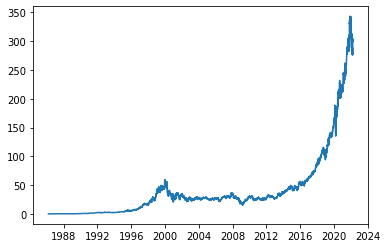

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

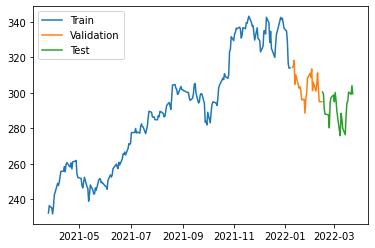

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 100ms/step - loss: 84627.8594 - mean_absolute_error: 289.1672 - val_loss: 92344.8672 - val_mean_absolute_error: 303.7958
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 84418.7578 - mean_absolute_error: 288.8058 - val_loss: 92101.9375 - val_mean_absolute_error: 303.3957
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 84147.9141 - mean_absolute_error: 288.3343 - val_loss: 91757.8594 - val_mean_absolute_error: 302.8282
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 83824.8047 - mean_absolute_error: 287.7752 - val_loss: 91415.5000 - val_mean_absolute_error: 302.2623
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 83455.3438 - mean_absolute_error: 287.1278 - val_loss: 90895.8594 - val_mean_absolute_error: 301.4015
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 82868.2422 - mean_absolute_error: 286.1076 - val_loss: 90171.

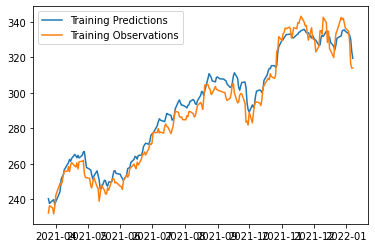

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

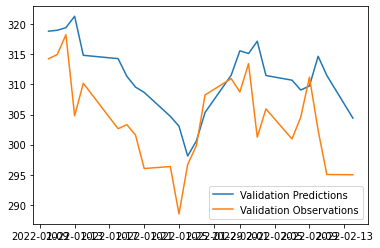

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

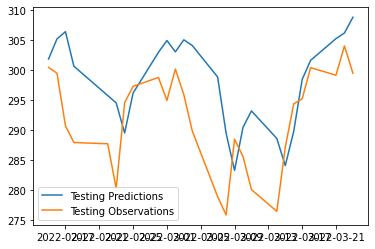

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

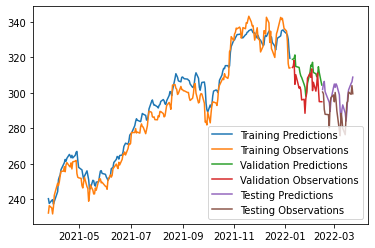

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

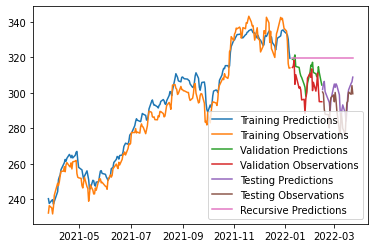

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])